In [2]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from keras.callbacks import EarlyStopping
#from gensim import corpora
#pd.set_option('display.max_rows', 1000000000)

In [5]:
labels_csv = pd.read_csv("data\\NAACL_SRW_2016.csv")
labels_csv.head()

,tweet_id,label
0,572342978255048705,racism
1,572341498827522049,racism
2,572340476503724032,racism
3,572334712804384768,racism
4,572332655397629952,racism


In [6]:
tweets_csv = pd.read_csv("data\\NAACL_SRW_2016_tweets.csv", header=0, delimiter=",bbbbbbbbbbb", quoting=3)

for i in range(len(tweets_csv)):
    s = tweets_csv.iloc[i,1]
    s = s[1:-1]
    tweets_csv.iloc[i,1] = s

tweets_csv.head()

C:\Users\Mahdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,tweet_id,tweet
0,572332655397629952,These girls are the equivalent of the irritati...
1,572341498827522049,Drasko they didn't cook half a bird you idiot ...
2,572340476503724032,Hopefully someone cooks Drasko in the next ep ...
3,572334712804384768,of course you were born in serbia...you're as ...
4,575949086055997440,#MKR Lost the plot - where's the big Texan wi...


In [8]:
merged = tweets_csv.merge(labels_csv, on='tweet_id')
merged = merged.drop_duplicates()
merged = merged.reset_index(drop=True)
merged.head()

,tweet_id,tweet,label
0,572332655397629952,These girls are the equivalent of the irritati...,racism
1,572341498827522049,Drasko they didn't cook half a bird you idiot ...,racism
2,572341498827522049,Drasko they didn't cook half a bird you idiot ...,none
3,572340476503724032,Hopefully someone cooks Drasko in the next ep ...,racism
4,572340476503724032,Hopefully someone cooks Drasko in the next ep ...,none


In [12]:
tweets_list = merged['tweet'].tolist()
labels_list = merged['label'].tolist()

max_wordNum = 0
for tweet in tweets_list:
    tweet_splitted = tweet.split()
    if len(tweet_splitted) > max_wordNum:
        max_wordNum = len(tweet_splitted)

In [14]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(tweets_list)
vocab_dict = vocab_processor.vocabulary_._mapping

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [15]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 200))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [16]:
M_pre_train=pre_trained_embedding(vocab_dict,'glove.twitter.27B\\glove.twitter.27B.200d.txt')

In [22]:
X = np.array(list(vocab_processor.transform(tweets_list)))

s = pd.Series(labels_list)
Y = np.array(pd.get_dummies(s))

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.333)

In [23]:
embedding_vecor_length = 200
class_count = Y.shape[1]

model = Sequential()
model.add(Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],input_shape=(max_wordNum,),trainable=True, name='Embedding'))
model.add(LSTM(100,return_sequences=False,name='LSTM'))
model.add(Dense(20,activation='relu',name='Hidden_Layer_1'))
model.add(Dense(class_count, activation='softmax', name='Softmax_Layer'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 33, 200)           4507400   
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               120400    
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 20)                2020      
_________________________________________________________________
Softmax_Layer (Dense)        (None, 3)                 63        
Total params: 4,629,883
Trainable params: 4,629,883
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

history = model.fit(X_train,y_train,
                    validation_data=[X_valid,y_valid],
                    epochs=50, 
                    batch_size=100
                    ,callbacks=callbacks
                   )

Train on 5572 samples, validate on 2782 samples
Epoch 1/50
5572/5572 [==============================] - 12s 2ms/step - loss: 0.6684 - acc: 0.7207 - val_loss: 0.4938 - val_acc: 0.8027
Epoch 2/50
5572/5572 [==============================] - 11s 2ms/step - loss: 0.4352 - acc: 0.8322 - val_loss: 0.3953 - val_acc: 0.8372
Epoch 3/50
5572/5572 [==============================] - 11s 2ms/step - loss: 0.2702 - acc: 0.9051 - val_loss: 0.3683 - val_acc: 0.8627
Epoch 4/50
5572/5572 [==============================] - 11s 2ms/step - loss: 0.1496 - acc: 0.9528 - val_loss: 0.4041 - val_acc: 0.8523
Epoch 5/50
5572/5572 [==============================] - 11s 2ms/step - loss: 0.0872 - acc: 0.9763 - val_loss: 0.4775 - val_acc: 0.8584
Epoch 6/50
5572/5572 [==============================] - 11s 2ms/step - loss: 0.0535 - acc: 0.9876 - val_loss: 0.5370 - val_acc: 0.8512
Epoch 7/50
5572/5572 [==============================] - 11s 2ms/step - loss: 0.0449 - acc: 0.9898 - val_loss: 0.5441 - val_acc: 0.8562
Epoch 8

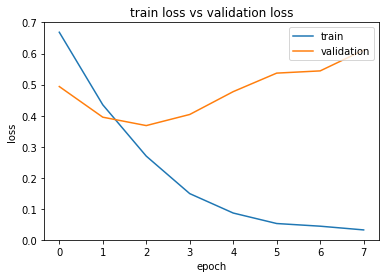

In [25]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6523204144424403
Test accuracy: 0.8470377019748654
